In [1]:
from datetime import datetime
import json
from collections import Counter

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
import torchmetrics

from deeprec.torch.trainer import Trainer, set_device
from deeprec import ROOT

In [2]:
with open('../data/metadata.json', 'r') as fp:
    meta = json.load(fp)

meta.keys()

dict_keys(['title_emb_size', 'string_na', 'genres', 'ages', 'occupations', 'user', 'movie', 'city', 'state'])

In [54]:
len(Counter([2, 1, 3]))

3

In [55]:
class Vocab(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, x):
        c = Counter(x)
        self.lookup_ = {
            str(v).lower(): k for k, v in enumerate([x[0] for x in sorted(c.items(), key=lambda x: x[1], reverse=True)])
        }

    def transform(self, x):
        return [self.lookup_.get(str(xx).lower(), len(self.lookup_)+1) for xx in x]

In [102]:
state_enc = Vocab()
state_enc.fit(meta['state'])

city_enc = Vocab()
city_enc.fit(meta['city'])

user_enc = Vocab()
user_enc.fit(meta['user'])

movie_enc = Vocab()
movie_enc.fit(meta['movie'])

In [57]:
df = pd.read_parquet('../data/train.parq.gzip').drop('rating', axis=1)
df.head()

,user,movie,hour,day_of_week,month,gender,age,occupation,city,state,...,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24
index,,,,,,,,,,,,,,,,,,,,,
956151,6036,3132,1,2,4,1,25,15,Gainesville,FL,...,0.511667,1.46494,-2.46967,-1.196152,-0.7946,-0.09462,2.84776,2.17518,1.03427,-0.75034
956152,6037,3132,3,2,4,1,45,1,Arlington,TX,...,0.511667,1.46494,-2.46967,-1.196152,-0.7946,-0.09462,2.84776,2.17518,1.03427,-0.75034
956149,5960,3132,17,5,4,1,45,0,Slidell,LA,...,0.511667,1.46494,-2.46967,-1.196152,-0.7946,-0.09462,2.84776,2.17518,1.03427,-0.75034
956150,6016,3132,20,2,4,0,45,1,Nashville,TN,...,0.511667,1.46494,-2.46967,-1.196152,-0.7946,-0.09462,2.84776,2.17518,1.03427,-0.75034
956146,5643,3132,6,6,5,1,35,1,Salt Lake City,UT,...,0.511667,1.46494,-2.46967,-1.196152,-0.7946,-0.09462,2.84776,2.17518,1.03427,-0.75034


In [58]:
df = pd.read_parquet('../data/train.parq.gzip', columns=['rating'])
df.head()

,rating
index,
956151,5
956152,4
956149,5
956150,3
956146,4


In [59]:
set(df['rating'])

{1, 2, 3, 4, 5}

In [103]:
class MovieDataset(Dataset):
    def __init__(self, filename, vocabs):
        x = pd.read_parquet(filename).drop('rating', axis=1)
        y = pd.read_parquet(filename, columns=['rating'])

        x['state'] = vocabs['state'].transform(x['state'])
        x['city'] = vocabs['city'].transform(x['city'])
        x['user'] = vocabs['user'].transform(x['user'])
        x['movie'] = vocabs['movie'].transform(x['movie'])

        self.feature_names = x.columns
        self.x = x.to_dict('records')
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [104]:
encoders = {
    'user': user_enc,
    'movie': movie_enc,
    'city': city_enc,
    'state': state_enc
}

train = MovieDataset('../data/train.parq.gzip', vocabs=encoders)
test = MovieDataset('../data/test.parq.gzip', vocabs=encoders)

In [30]:
print(len(train.feature_names))
train.feature_names

54


Index(['user', 'movie', 'hour', 'day_of_week', 'month', 'gender', 'age',
       'occupation', 'city', 'state', 'year', 'genre_action',
       'genre_adventure', 'genre_animation', 'genre_childrens', 'genre_comedy',
       'genre_crime', 'genre_documentary', 'genre_drama', 'genre_fantasy',
       'genre_filmnoir', 'genre_horror', 'genre_musical', 'genre_mystery',
       'genre_romance', 'genre_scifi', 'genre_thriller', 'genre_war',
       'genre_western', 'embed_0', 'embed_1', 'embed_2', 'embed_3', 'embed_4',
       'embed_5', 'embed_6', 'embed_7', 'embed_8', 'embed_9', 'embed_10',
       'embed_11', 'embed_12', 'embed_13', 'embed_14', 'embed_15', 'embed_16',
       'embed_17', 'embed_18', 'embed_19', 'embed_20', 'embed_21', 'embed_22',
       'embed_23', 'embed_24'],
      dtype='object')

In [31]:
dl = DataLoader(train, 4)
next(iter(dl))

[{'user': tensor([  66, 1566, 1665,   60]),
  'movie': tensor([3132, 3132, 3132, 3132]),
  'hour': tensor([ 1,  3, 17, 20]),
  'day_of_week': tensor([2, 2, 5, 2]),
  'month': tensor([4, 4, 4, 4]),
  'gender': tensor([1, 1, 1, 0]),
  'age': tensor([25, 45, 45, 45]),
  'occupation': tensor([15,  1,  0,  1]),
  'city': tensor([   61,    34, 99999,    38]),
  'state': tensor([    9,     4, 99999, 99999]),
  'year': tensor([1919, 1919, 1919, 1919]),
  'genre_action': tensor([0, 0, 0, 0]),
  'genre_adventure': tensor([0, 0, 0, 0]),
  'genre_animation': tensor([0, 0, 0, 0]),
  'genre_childrens': tensor([0, 0, 0, 0]),
  'genre_comedy': tensor([1, 1, 1, 1]),
  'genre_crime': tensor([0, 0, 0, 0]),
  'genre_documentary': tensor([0, 0, 0, 0]),
  'genre_drama': tensor([0, 0, 0, 0]),
  'genre_fantasy': tensor([0, 0, 0, 0]),
  'genre_filmnoir': tensor([0, 0, 0, 0]),
  'genre_horror': tensor([0, 0, 0, 0]),
  'genre_musical': tensor([0, 0, 0, 0]),
  'genre_mystery': tensor([0, 0, 0, 0]),
  'genre_roman

In [36]:
z = next(iter(dl))

In [37]:
def stack_features(inputs, feat):
    return torch.stack([v for k, v in inputs.items() if feat in k], 1)


stack_features(z[0], 'genre')

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [137]:
class RecModel(nn.Module):
    def __init__(self, metadata, n_features=54):
        super().__init__()
        self.meta = metadata
        self.embed_dims = {
            'large': 25,
            'med': 7,
            'small': 3
        }
        self.loss_func = nn.MSELoss()

        self.user_embeds = nn.Embedding(
            num_embeddings=len(meta['user'].keys()) + 2,
            embedding_dim=self.embed_dims['large']
        )

        self.city_embeds = nn.Embedding(
            num_embeddings=len(meta['city'].keys()) + 2,
            embedding_dim=self.embed_dims['med']
        )

        self.state_embeds = nn.Embedding(
            num_embeddings=len(meta['state'].keys()) + 2,
            embedding_dim=self.embed_dims['small']
        )

        self.age_embeds = nn.Embedding(
            num_embeddings=max(meta['ages']) + 1,
            embedding_dim=self.embed_dims['small']
        )

        self.occ_embeds = nn.Embedding(
            num_embeddings=max(meta['occupations']) + 1,
            embedding_dim=self.embed_dims['small']
        )

        self.user_model = nn.Sequential(
            nn.LazyLinear(out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU()
        )

        self.movie_embeds = nn.Embedding(
            num_embeddings=len(meta['movie'].keys()) + 2,
            embedding_dim=self.embed_dims['large']
        )

        self.title_embeds = nn.Sequential(
            nn.Linear(in_features=25, out_features=25),
            nn.Softmax()
        )

        self.movie_model = nn.Sequential(
            nn.LazyLinear(out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU()
        )

        self.model = nn.Sequential(
            nn.LazyLinear(out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)
        )

    def forward(self, x):
        x_user = torch.concat(
            (
                self.user_embeds(x['user']),
                self.city_embeds(x['city']),
                self.state_embeds(x['state']),
                self.age_embeds(x['age']),
                self.occ_embeds(x['occupation']),
                x['gender'].unsqueeze(-1),
                x['hour'].unsqueeze(-1),
                x['day_of_week'].unsqueeze(-1),
                x['month'].unsqueeze(-1)
            ),
            dim=1
        )

        x_movie = torch.concat(
            (
                self.movie_embeds(x['movie']),
                self.title_embeds(stack_features(x, 'embed').float()),
                stack_features(x, 'genre'),
                x['year'].unsqueeze(-1)
            ),
            dim=1
        )
        user_block = self.user_model(x_user)
        movie_block = self.movie_model(x_movie.float())
        x = self.model(torch.mul(user_block, movie_block))
        return x

    def predict(self, x):
        return self(x)

In [ ]:
NOW = datetime.now().strftime('%Y%m%d-%H%M')
LOG_DIR = ROOT.joinpath('runs', NOW)
BATCH = 10_000

train_loader = DataLoader(train, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH)

device = set_device()
mod = RecModel(metadata=meta)
opt = torch.optim.AdamW(mod.parameters(), lr=0.001)
trainer = Trainer(
    mod, epochs=100, device=device, log_dir=LOG_DIR, checkpoint_file=LOG_DIR.joinpath('model.pt'),
    optimizer=opt, score_funcs={'mse': torchmetrics.MeanSquaredError()}
)
trainer.fit(train_loader, test_loader, verbose=True)

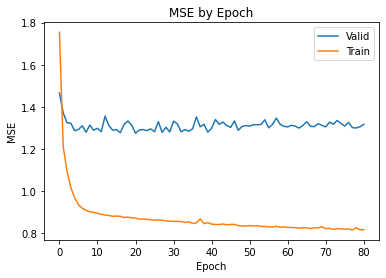

In [156]:
import matplotlib.pyplot as plt

plt.plot(trainer.results['valid_mse'], label='Valid')
plt.plot(trainer.results['train_mse'], label='Train')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('MSE by Epoch')
plt.show()

In [129]:
{e:v for e,v in enumerate(torch.sqrt(torch.tensor(trainer.results['valid_mse'])))}

{0: tensor(1.1409),
 1: tensor(1.1329),
 2: tensor(1.1136),
 3: tensor(1.1165),
 4: tensor(1.1138)}

<hr>

# DEBUGGING

In [62]:
dl = DataLoader(train, 32)
z = next(iter(dl))
z

[{'user': tensor([  66, 1566, 1665,   60,   30, 2355, 1692,   64,  934, 1067, 1065, 2515,
           566, 1637,  862,  129,  219, 1960,   17,   28,  441,  327,   53,  431,
            27,  812, 2028,  803,  137, 2515, 1158,  682]),
  'movie': tensor([3132, 3132, 3132, 3132, 3132, 2821, 3132, 3132, 3132, 3132, 3132, 3132,
          3132, 3132, 3132, 3132, 3132, 3132, 3132, 2823, 3132, 3132, 3132, 3132,
          3132, 3132, 3132, 3132, 3132, 3132, 3132, 2823]),
  'hour': tensor([ 1,  3, 17, 20,  6, 21,  6,  7, 23, 23, 12, 21, 21, 21,  0,  0,  2, 14,
          15, 18,  4, 13, 16, 16, 17,  8, 21,  2,  3,  4,  6,  8]),
  'day_of_week': tensor([2, 2, 5, 2, 6, 2, 0, 5, 3, 3, 2, 5, 4, 5, 4, 5, 0, 3, 3, 0, 6, 3, 0, 1,
          5, 1, 2, 4, 1, 0, 2, 2]),
  'month': tensor([ 4,  4,  4,  4,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,
           8,  8,  9,  9,  9,  9,  9, 10, 10, 11, 11, 11, 11, 11]),
  'gender': tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,

In [86]:
user_embeds = nn.Embedding(
    num_embeddings=max(meta['occupations'])+1,
    embedding_dim=25
)

In [93]:
user_embeds(z[0]['occupation']).shape

torch.Size([32, 25])

In [120]:
z[0]['gender'].dtype

torch.int64

In [121]:
stack_features(z[0], 'genre').float()

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0.,

In [122]:
meta['movie']

{'2858': 0.003427283697707179,
 '260': 0.002990375011622571,
 '1196': 0.002989375220578899,
 '1210': 0.0028823975789060087,
 '480': 0.0026714416686912435,
 '2028': 0.002652445638861478,
 '589': 0.0026484464746867904,
 '2571': 0.0025894588031101498,
 '1270': 0.002582460265804447,
 '593': 0.0025774613105860873,
 '1580': 0.0025374696688392124,
 '1198': 0.0025134746837910875,
 '608': 0.0025124748927474157,
 '2762': 0.002458486176389135,
 '110': 0.002442489519690385,
 '2396': 0.002368504982458666,
 '1197': 0.0023175156392314005,
 '527': 0.0023035185646199945,
 '1617': 0.0022875219079212445,
 '1265': 0.0022775239974845256,
 '1097': 0.002268525878091479,
 '2628': 0.002249529848261713,
 '2997': 0.0022405317288686664,
 '318': 0.0022265346542572604,
 '858': 0.002222535490082573,
 '356': 0.0021935415498160883,
 '2716': 0.002180544266248354,
 '296': 0.0021705463558116356,
 '1240': 0.0020975616096235885,
 '1': 0.0020765659977064793,
 '1214': 0.00202357707239187,
 '2916': 0.0019955829231690578,
 '45